In [0]:
import numpy as np
import pandas as pd
import copy
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
import lightgbm as lgb
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, roc_auc_score

In [0]:
train = pd.read_csv("/content/drive/My Drive/Colab Notebooks/Foreclosure/train_foreclosure.csv")
test = pd.read_csv("/content/drive/My Drive/Colab Notebooks/Foreclosure/test_foreclosure.csv")
# customer = pd.read_excel("/content/drive/My Drive/Colab Notebooks/Foreclosure/Customers_31JAN2019.xlsx")
agreement = pd.read_excel("/content/drive/My Drive/Colab Notebooks/Foreclosure/LMS_31JAN2019.xlsx")
# email = pd.read_excel("/content/drive/My Drive/Colab Notebooks/Foreclosure/RF_Final_Data.xlsx")

In [0]:
train.head(3)

,AGREEMENTID,FORECLOSURE
0,11220001,1
1,11220002,1
2,11220006,1


In [0]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20012 entries, 0 to 20011
Data columns (total 2 columns):
AGREEMENTID    20012 non-null int64
FORECLOSURE    20012 non-null int64
dtypes: int64(2)
memory usage: 312.8 KB


In [0]:
train['FORECLOSURE'].value_counts()

0    18217
1     1795
Name: FORECLOSURE, dtype: int64

In [0]:
test.head(3)

,AGREEMENTID,FORECLOSURE
0,11220003,NaN
1,11220004,NaN
2,11220005,NaN


In [0]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13342 entries, 0 to 13341
Data columns (total 2 columns):
AGREEMENTID    13342 non-null int64
FORECLOSURE    0 non-null float64
dtypes: float64(1), int64(1)
memory usage: 208.5 KB


In [0]:
agreement.iloc[:10, 20:30]

,BALANCE_EXCESS,NET_RECEIVABLE,OUTSTANDING_PRINCIPAL,PAID_PRINCIPAL,PAID_INTEREST,MONTHOPENING,LAST_RECEIPT_DATE,LAST_RECEIPT_AMOUNT,NET_LTV,COMPLETED_TENURE
0,0.00000,184544.396568,2.262177e+06,9.447930e+06,2.617476e+06,9.338009e+06,2013-11-01,83559.0,40.06,39
1,0.00000,279448.084560,1.234760e+07,6.942656e+06,4.945154e+06,1.713861e+07,2013-11-01,126530.0,84.31,38
2,0.44171,-0.441710,3.944954e+06,1.085444e+05,1.549566e+06,3.944954e+06,2013-11-05,30898.0,79.34,38
3,0.00000,0.000000,1.030278e+07,2.954253e+06,4.219464e+06,1.255472e+07,2013-11-05,88256.0,86.86,37
4,0.00000,0.000000,8.479158e+06,4.732245e+06,3.812974e+06,1.178201e+07,2013-11-05,91892.0,40.93,38
5,0.00000,0.000000,3.830337e+06,1.030583e+05,1.360684e+06,3.830337e+06,2013-11-05,28518.0,50.89,36
6,0.00000,0.000000,5.929700e+06,2.256132e+05,2.067353e+06,5.929700e+06,2013-11-05,47247.0,45.32,28
7,0.00000,145192.417032,8.211513e+06,1.811075e+06,2.984047e+06,9.412549e+06,2013-11-01,65741.0,84.63,37
8,0.00000,15097.661472,9.228138e+06,2.711462e+05,3.796394e+06,9.228138e+06,2013-11-05,77530.0,52.34,34
9,0.00000,0.000000,7.511708e+06,2.442289e+05,2.573672e+06,7.511708e+06,2013-11-05,54433.0,30.94,36


In [0]:
agreement.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 624250 entries, 0 to 624249
Data columns (total 38 columns):
AGREEMENTID              624250 non-null int64
CUSTOMERID               623734 non-null float64
LOAN_AMT                 624250 non-null float64
NET_DISBURSED_AMT        624250 non-null float64
INTEREST_START_DATE      624250 non-null datetime64[ns]
CURRENT_ROI              624250 non-null float64
ORIGNAL_ROI              624250 non-null float64
CURRENT_TENOR            624245 non-null float64
ORIGNAL_TENOR            624250 non-null int64
DUEDAY                   624250 non-null int64
AUTHORIZATIONDATE        624250 non-null datetime64[ns]
CITY                     624242 non-null object
PRE_EMI_DUEAMT           624250 non-null float64
PRE_EMI_RECEIVED_AMT     624250 non-null float64
PRE_EMI_OS_AMOUNT        624250 non-null float64
EMI_DUEAMT               624250 non-null float64
EMI_RECEIVED_AMT         624250 non-null float64
EMI_OS_AMOUNT            624250 non-null float64


In [0]:
len(agreement['AGREEMENTID'].unique())

33354

In [0]:
df = agreement.copy()

In [0]:
df.shape

(624250, 38)

In [0]:
df.head(5)

,AGREEMENTID,CUSTOMERID,LOAN_AMT,NET_DISBURSED_AMT,INTEREST_START_DATE,CURRENT_ROI,ORIGNAL_ROI,CURRENT_TENOR,ORIGNAL_TENOR,DUEDAY,...,NET_LTV,COMPLETED_TENURE,BALANCE_TENURE,DPD,FOIR,PRODUCT,SCHEMEID,NPA_IN_LAST_MONTH,NPA_IN_CURRENT_MONTH,MOB
0,11220001,12001000.0,1.171011e+07,1.171011e+07,2010-08-30,13.734072,10.612692,58.0,120,1,...,40.06,39,19.0,0.0,0.6000,HL,10901100.0,NaN,NaN,39
1,11220002,12001001.0,1.929025e+07,1.929025e+07,2010-09-15,13.734072,10.612692,137.0,180,1,...,84.31,38,99.0,0.0,0.6000,HL,10901100.0,NaN,NaN,38
2,11220003,12001002.0,4.053499e+06,4.053499e+06,2010-09-06,17.167590,12.485520,360.0,180,5,...,79.34,38,322.0,0.0,0.9100,HL,10901101.0,NaN,NaN,38
3,11220004,12001003.0,1.325703e+07,1.325703e+07,2010-09-29,15.606900,10.924830,198.0,180,5,...,86.86,37,161.0,0.0,0.9686,HL,10901101.0,NaN,NaN,38
4,11220005,12001004.0,1.321140e+07,1.321140e+07,2010-09-06,16.543314,11.861244,142.0,180,5,...,40.93,38,104.0,0.0,0.7300,HL,10901101.0,NaN,NaN,38


In [0]:
cat = df.select_dtypes(include=['O']) 
cat.apply(pd.Series.nunique) 

CITY                    316
PRODUCT                   4
NPA_IN_LAST_MONTH         5
NPA_IN_CURRENT_MONTH      3
dtype: int64

In [0]:
# created a dataframe containing count of AGREEMENTID
count_df = df.groupby('AGREEMENTID').count().reset_index()
count_df['Count'] = count_df['LOAN_AMT']
count_df = count_df[['AGREEMENTID', 'Count']]

In [0]:
count_df.head(7)

,AGREEMENTID,Count
0,11220001,7
1,11220002,1
2,11220003,50
3,11220004,1
4,11220005,9
5,11220006,46
6,11220007,10


In [0]:
pro_encoder = LabelEncoder()

df['PRODUCT'] = pro_encoder.fit_transform(df['PRODUCT'].astype(str).values.reshape(-1, 1))

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [0]:
# created new dataframe to remove multiple entries of AGREEMENTID bygrouping it on median basis
dff = df.groupby(['AGREEMENTID']).median().reset_index()

In [0]:
# merge it with train and test dataset
mergetrain_df = pd.merge(dff, train, on=['AGREEMENTID'])
mergetest_df = pd.merge(dff, test, on=['AGREEMENTID'])

In [0]:
# merge both created datasets
train_df = pd.merge(count_df, mergetrain_df, on=['AGREEMENTID'])
test_df = pd.merge(count_df, mergetest_df, on=['AGREEMENTID'])

In [0]:
train_df.head()

,AGREEMENTID,Count,CUSTOMERID,LOAN_AMT,NET_DISBURSED_AMT,CURRENT_ROI,ORIGNAL_ROI,CURRENT_TENOR,ORIGNAL_TENOR,DUEDAY,...,LAST_RECEIPT_AMOUNT,NET_LTV,COMPLETED_TENURE,BALANCE_TENURE,DPD,FOIR,PRODUCT,SCHEMEID,MOB,FORECLOSURE
0,11220001,7,12001000.0,1.171011e+07,1.171011e+07,13.421934,10.612692,58.0,120.0,1.0,...,83559.0,40.06,41.0,17.0,0.0,0.60,0.0,10901100.0,42.0,1
1,11220002,1,12001001.0,1.929025e+07,1.929025e+07,13.734072,10.612692,137.0,180.0,1.0,...,126530.0,84.31,38.0,99.0,0.0,0.60,0.0,10901100.0,38.0,1
2,11220006,46,12001005.0,3.933395e+06,3.933395e+06,16.231176,11.549106,343.5,180.0,5.0,...,22878.0,50.89,58.5,284.0,0.0,0.72,0.0,10901101.0,58.5,1
3,11220008,55,12001007.0,1.002259e+07,1.002259e+07,12.797658,10.612692,91.0,180.0,1.0,...,65741.0,84.63,64.0,27.0,0.0,0.60,0.0,10901100.0,64.0,1
4,11220010,54,12001009.0,7.755937e+06,7.755937e+06,15.294762,10.924830,318.0,180.0,5.0,...,54433.0,30.94,62.5,255.5,0.0,0.83,0.0,10901101.0,63.5,1


In [0]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20012 entries, 0 to 20011
Data columns (total 34 columns):
AGREEMENTID              20012 non-null int64
Count                    20012 non-null int64
CUSTOMERID               19731 non-null float64
LOAN_AMT                 20012 non-null float64
NET_DISBURSED_AMT        20012 non-null float64
CURRENT_ROI              20012 non-null float64
ORIGNAL_ROI              20012 non-null float64
CURRENT_TENOR            20012 non-null float64
ORIGNAL_TENOR            20012 non-null float64
DUEDAY                   20012 non-null float64
PRE_EMI_DUEAMT           20012 non-null float64
PRE_EMI_RECEIVED_AMT     20012 non-null float64
PRE_EMI_OS_AMOUNT        20012 non-null float64
EMI_DUEAMT               20012 non-null float64
EMI_RECEIVED_AMT         20012 non-null float64
EMI_OS_AMOUNT            20012 non-null float64
EXCESS_AVAILABLE         20012 non-null float64
EXCESS_ADJUSTED_AMT      20012 non-null float64
BALANCE_EXCESS           20012 

In [0]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13342 entries, 0 to 13341
Data columns (total 34 columns):
AGREEMENTID              13342 non-null int64
Count                    13342 non-null int64
CUSTOMERID               13164 non-null float64
LOAN_AMT                 13342 non-null float64
NET_DISBURSED_AMT        13342 non-null float64
CURRENT_ROI              13342 non-null float64
ORIGNAL_ROI              13342 non-null float64
CURRENT_TENOR            13342 non-null float64
ORIGNAL_TENOR            13342 non-null float64
DUEDAY                   13342 non-null float64
PRE_EMI_DUEAMT           13342 non-null float64
PRE_EMI_RECEIVED_AMT     13342 non-null float64
PRE_EMI_OS_AMOUNT        13342 non-null float64
EMI_DUEAMT               13342 non-null float64
EMI_RECEIVED_AMT         13342 non-null float64
EMI_OS_AMOUNT            13342 non-null float64
EXCESS_AVAILABLE         13342 non-null float64
EXCESS_ADJUSTED_AMT      13342 non-null float64
BALANCE_EXCESS           13342 

In [0]:
# test_df[test_df['DPD'].isnull()] #test to check data for all columns having missing values

In [0]:
# impute missing values
imputer = SimpleImputer(missing_values=np.nan, strategy='median')
train_df['LAST_RECEIPT_AMOUNT'] = imputer.fit_transform(train_df['LAST_RECEIPT_AMOUNT'].values.reshape(-1, 1))
test_df['LAST_RECEIPT_AMOUNT'] = imputer.transform(test_df['LAST_RECEIPT_AMOUNT'].values.reshape(-1, 1))  #
train_df['SCHEMEID'] = imputer.fit_transform(train_df['SCHEMEID'].values.reshape(-1, 1))
test_df['SCHEMEID'] = imputer.transform(test_df['SCHEMEID'].values.reshape(-1, 1))
test_df['DPD'] = test_df['DPD'].fillna(0)

In [0]:
# new features
train_df['ROI_diff'] = train_df['CURRENT_ROI'] - train_df['ORIGNAL_ROI']
train_df['TENOR_diff'] = train_df['ORIGNAL_TENOR'] - train_df['CURRENT_TENOR']
train_df['TENURE_diff'] = train_df['BALANCE_TENURE'] - train_df['COMPLETED_TENURE']
train_df['PRE_EMI'] = train_df['PRE_EMI_DUEAMT'] == train_df['PRE_EMI_RECEIVED_AMT']
train_df['PRE_EMI_diff'] = train_df['PRE_EMI_DUEAMT'] - train_df['PRE_EMI_RECEIVED_AMT']
train_df['EMI'] = train_df['EMI_DUEAMT'] == train_df['EMI_RECEIVED_AMT']
train_df['EMI_diff'] = train_df['EMI_DUEAMT'] - train_df['EMI_RECEIVED_AMT']
train_df['PRINCIPAL_diff'] = train_df['OUTSTANDING_PRINCIPAL'] - train_df['PAID_PRINCIPAL']
# train_df['TOTAL_OUTSTAND'] = train_df['PRE_EMI_OS_AMOUNT'] + train_df['EMI_OS_AMOUNT']

In [0]:
# new features
test_df['ROI_diff'] = test_df['CURRENT_ROI'] - test_df['ORIGNAL_ROI']
test_df['TENOR_diff'] = test_df['ORIGNAL_TENOR'] - test_df['CURRENT_TENOR']
test_df['TENURE_diff'] = test_df['BALANCE_TENURE'] - test_df['COMPLETED_TENURE']
test_df['PRE_EMI'] = test_df['PRE_EMI_DUEAMT'] == test_df['PRE_EMI_RECEIVED_AMT']
test_df['PRE_EMI_diff'] = test_df['PRE_EMI_DUEAMT'] - test_df['PRE_EMI_RECEIVED_AMT']
test_df['EMI'] = test_df['EMI_DUEAMT'] == test_df['EMI_RECEIVED_AMT']
test_df['EMI_diff'] = test_df['EMI_DUEAMT'] - test_df['EMI_RECEIVED_AMT']
test_df['PRINCIPAL_diff'] = test_df['OUTSTANDING_PRINCIPAL'] - test_df['PAID_PRINCIPAL']
# test_df['TOTAL_OUTSTAND'] = test_df['PRE_EMI_OS_AMOUNT'] + test_df['EMI_OS_AMOUNT']

In [0]:
# train_df.head()

In [0]:
# train_df.info()

In [0]:
# test_df.head()

In [0]:
# test_df.info()

In [0]:
# including all previous and new features in train data
train_df = train_df[['AGREEMENTID', 'LOAN_AMT', 'ROI_diff', 'TENOR_diff', 'DUEDAY', 'PRE_EMI', 'PRE_EMI_OS_AMOUNT', 'EMI', 'NET_RECEIVABLE', 'OUTSTANDING_PRINCIPAL', 
         'PAID_PRINCIPAL', 'PAID_INTEREST', 'MONTHOPENING', 'LAST_RECEIPT_AMOUNT', 'NET_LTV', 'TENURE_diff', 'DPD', 'FOIR', 'PRODUCT', 'SCHEMEID', 'MOB', 
                     'FORECLOSURE', 'PRE_EMI_diff', 'EMI_diff', 'Count', 'CURRENT_ROI', 'ORIGNAL_ROI', 'ORIGNAL_TENOR', 'CURRENT_TENOR', 'BALANCE_TENURE', 
                     'COMPLETED_TENURE', 'PRE_EMI_DUEAMT', 'PRE_EMI_RECEIVED_AMT', 'EMI_DUEAMT', 'EMI_RECEIVED_AMT', 'PRINCIPAL_diff']]

In [0]:
# including all previous and new features in test data
test_df = test_df[['AGREEMENTID', 'LOAN_AMT', 'ROI_diff', 'TENOR_diff', 'DUEDAY', 'PRE_EMI', 'PRE_EMI_OS_AMOUNT', 'EMI', 'NET_RECEIVABLE', 'OUTSTANDING_PRINCIPAL', 
         'PAID_PRINCIPAL', 'PAID_INTEREST', 'MONTHOPENING', 'LAST_RECEIPT_AMOUNT', 'NET_LTV', 'TENURE_diff', 'DPD', 'FOIR', 'PRODUCT', 'SCHEMEID', 'MOB', 
                   'FORECLOSURE', 'PRE_EMI_diff', 'EMI_diff', 'Count', 'CURRENT_ROI', 'ORIGNAL_ROI','ORIGNAL_TENOR', 'CURRENT_TENOR', 'BALANCE_TENURE', 
                   'COMPLETED_TENURE', 'PRE_EMI_DUEAMT', 'PRE_EMI_RECEIVED_AMT', 'EMI_DUEAMT', 'EMI_RECEIVED_AMT', 'PRINCIPAL_diff']]

In [0]:
# making lists for categorical and numerical features for further processing
cat_col = ['PRE_EMI', 'EMI', 'PRODUCT', 'SCHEMEID']
num_col = ['AGREEMENTID', 'LOAN_AMT', 'ROI_diff', 'TENOR_diff', 'DUEDAY', 'PRE_EMI_OS_AMOUNT', 'NET_RECEIVABLE', 'OUTSTANDING_PRINCIPAL', 'PAID_PRINCIPAL',
          'PAID_INTEREST', 'MONTHOPENING', 'LAST_RECEIPT_AMOUNT', 'NET_LTV', 'TENURE_diff', 'DPD', 'FOIR', 'MOB', 'PRE_EMI_diff', 'EMI_diff', 'Count',
          'CURRENT_ROI', 'ORIGNAL_ROI', 'ORIGNAL_TENOR', 'CURRENT_TENOR', 'BALANCE_TENURE', 
                     'COMPLETED_TENURE', 'PRE_EMI_DUEAMT', 'PRE_EMI_RECEIVED_AMT', 'EMI_DUEAMT', 'EMI_RECEIVED_AMT', 'PRINCIPAL_diff']

In [0]:
# standardized numerical columns
scaler = StandardScaler()

for i in num_col:
  train_df[i] = scaler.fit_transform(train_df[i].values.reshape(-1, 1))
  test_df[i] = scaler.transform(test_df[i].values.reshape(-1, 1))

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by Stand

In [0]:
# encoded categorical features
encoder = LabelEncoder()

for i in cat_col:
  train_df[i] = encoder.fit_transform(train_df[i].astype(str).values.reshape(-1, 1))
  test_df[i] = encoder.fit_transform(test_df[i].astype(str).values.reshape(-1, 1))

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [0]:
train_df.head()

,AGREEMENTID,LOAN_AMT,ROI_diff,TENOR_diff,DUEDAY,PRE_EMI,PRE_EMI_OS_AMOUNT,EMI,NET_RECEIVABLE,OUTSTANDING_PRINCIPAL,...,ORIGNAL_ROI,ORIGNAL_TENOR,CURRENT_TENOR,BALANCE_TENURE,COMPLETED_TENURE,PRE_EMI_DUEAMT,PRE_EMI_RECEIVED_AMT,EMI_DUEAMT,EMI_RECEIVED_AMT,PRINCIPAL_diff
0,-1.729071,0.447394,5.867729,3.736632,-1.771933,1,-0.022037,1,0.535019,-0.295538,...,-1.454076,-1.419250,-2.628633,-3.167476,3.391414,-0.139326,-0.139210,1.696486,1.712068,-0.821397
1,-1.728967,1.031048,6.547348,2.618552,-1.771933,1,-0.022037,0,0.818425,0.555334,...,-1.454076,-0.073932,-0.990861,-1.538326,3.077474,0.161494,0.163315,2.375723,2.326320,0.011920
2,-1.728551,-0.151396,9.945446,-9.533212,-0.279575,1,-0.022037,1,-0.016075,-0.205575,...,-1.094421,-0.073932,3.290148,2.137197,5.222732,-0.145981,-0.145903,0.614862,0.622532,-0.192798
3,-1.728344,0.317459,4.508490,5.325483,-1.771933,1,-0.022037,0,0.417505,-0.257546,...,-1.454076,-0.073932,-1.944500,-2.968799,5.798289,0.030831,0.031912,2.046022,2.027815,-0.656535
4,-1.728136,0.142932,9.265827,-8.032631,-0.279575,1,-0.022037,1,-0.016075,0.151098,...,-1.334191,-0.073932,2.761501,1.570968,5.641319,-0.075142,-0.074662,1.551770,1.566294,0.115872


In [0]:
test_df.head()

,AGREEMENTID,LOAN_AMT,ROI_diff,TENOR_diff,DUEDAY,PRE_EMI,PRE_EMI_OS_AMOUNT,EMI,NET_RECEIVABLE,OUTSTANDING_PRINCIPAL,...,ORIGNAL_ROI,ORIGNAL_TENOR,CURRENT_TENOR,BALANCE_TENURE,COMPLETED_TENURE,PRE_EMI_DUEAMT,PRE_EMI_RECEIVED_AMT,EMI_DUEAMT,EMI_RECEIVED_AMT,PRINCIPAL_diff
0,-1.728863,-0.142148,9.265827,-8.679940,-0.279575,1,-0.022037,1,-0.016077,-0.134658,...,-0.734767,-0.073932,2.989545,1.789512,5.641319,-0.165321,-0.165353,0.758444,0.767164,-0.091105
1,-1.728759,0.566504,9.945446,-0.971073,-0.279575,1,-0.022037,1,-0.016075,0.388084,...,-1.334191,-0.073932,0.273747,-0.306529,2.972828,-0.072836,-0.072343,1.529035,1.543392,0.134381
2,-1.728655,0.562991,9.945446,2.324321,-0.279575,1,-0.022037,1,-0.016075,0.224180,...,-0.974536,-0.073932,-0.887205,-1.518458,3.496061,-0.165321,-0.165353,1.855045,1.871787,-0.115269
3,-1.728447,0.019687,8.586207,-4.737237,-0.279575,1,-0.022037,1,-0.016075,0.028352,...,-0.734767,-0.073932,1.600549,1.054408,2.501918,1.302671,1.310965,0.579560,0.586972,0.027612
4,-1.728240,0.277166,11.304686,-6.208395,-0.279575,1,-0.022037,1,-0.016075,0.298297,...,-0.303181,-0.073932,2.118831,1.451761,3.025151,0.447639,0.451084,1.336216,1.349163,0.232814


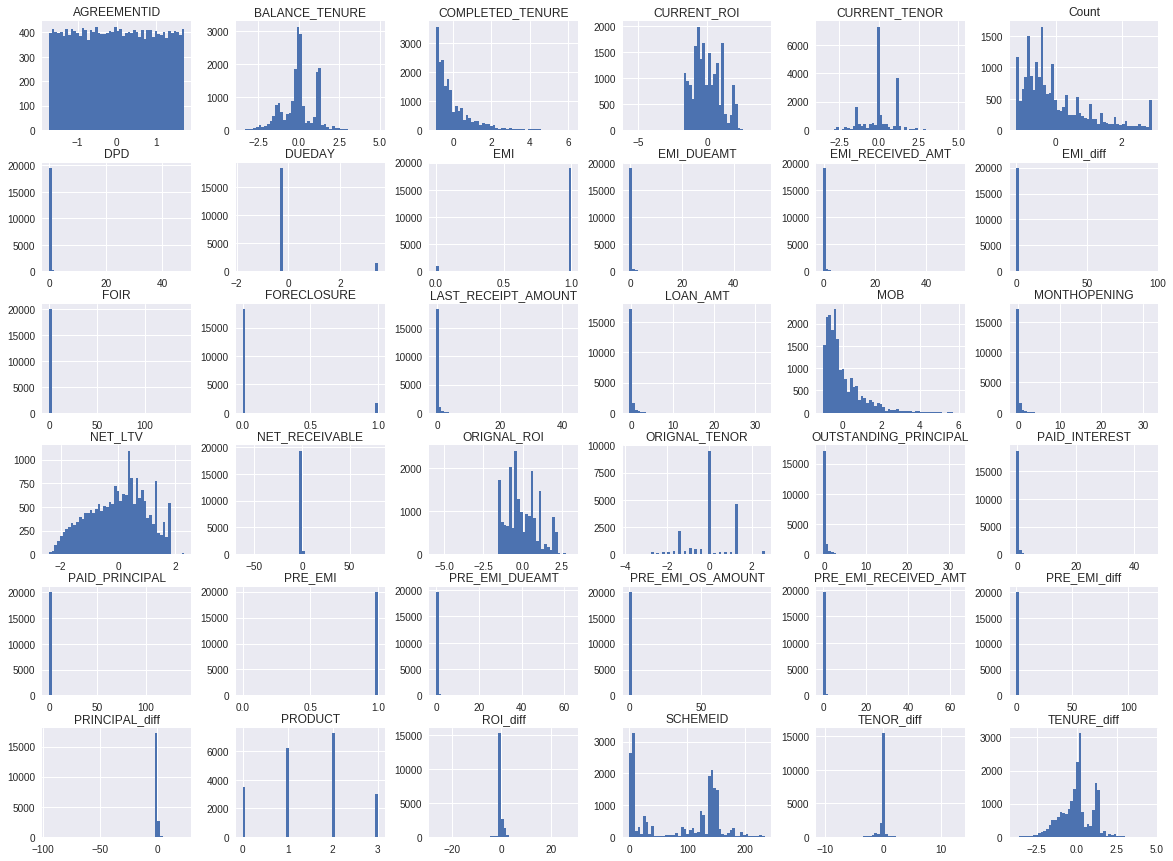

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
train_df.hist(bins=50, figsize=(20,15))
plt.show()

In [0]:
# log transformation on some features
cols = ['BALANCE_TENURE', 'COMPLETED_TENURE', 'CURRENT_ROI', 'CURRENT_TENOR', 'MOB', 'NET_LTV']
for col in cols:
  train_df[col] = np.log(train_df[col])
  test_df[col] = np.log(test_df[col])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log
  after removing the cwd from sys.path.


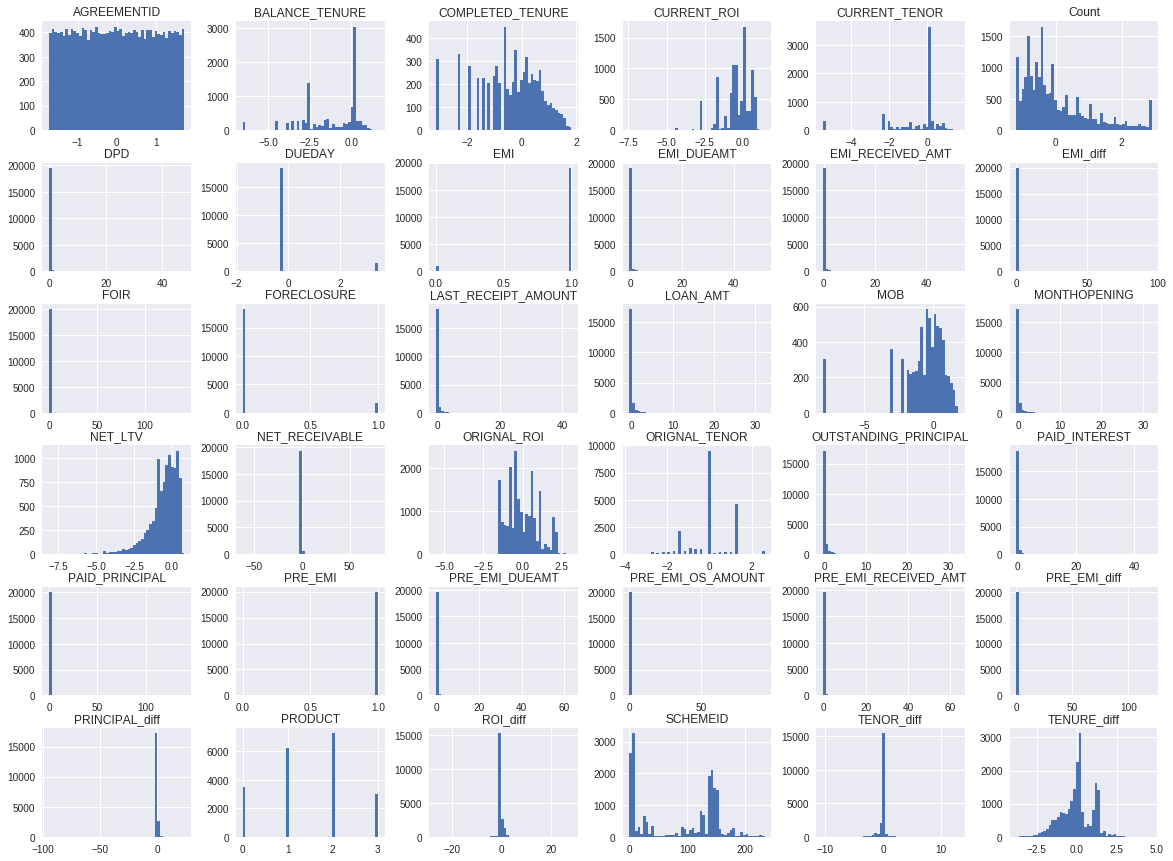

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
train_df.hist(bins=50, figsize=(20,15))
plt.show()

In [0]:
# columns = train_df.columns
# for i in columns:
#   print(i)
#   print(train_df[train_df[i].isnull()])

In [0]:
X = train_df.drop(columns=['FORECLOSURE'])
y = train_df['FORECLOSURE']
Xtest = test_df.drop(columns=['FORECLOSURE'])

In [0]:
# splitting data to train-test
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, stratify=y, random_state=0)

In [0]:
# LightGBM model
d_train = lgb.Dataset(X_train, label=y_train)

params = {}
params['learning_rate'] = 0.21
params['boosting_type'] = 'gbdt'
params['objective'] = 'binary'
params['metric'] = 'binary_logloss'
params['sub_feature'] = 0.5
params['num_leaves'] = 35
params['min_data'] = 50
params['max_depth'] = 8
model = lgb.train(params, d_train, 400)

y_pred = model.predict(X_test)

for i in range(len(y_pred)):
    if y_pred[i]>=.5:       
       y_pred[i]=1
    else:  
       y_pred[i]=0
print('Accuracy:', accuracy_score(y_pred, y_test.values))
print('AUC score:', roc_auc_score(y_test.values, y_pred))

Accuracy: 0.9930052460654509
AUC score: 0.9672805145406347


In [0]:
d_trainn = lgb.Dataset(X, label=y)

model = lgb.train(params, d_trainn, 400)

y_predict = model.predict(Xtest)

In [0]:
test['FORECLOSURE'] = y_predict
test.to_csv('/content/drive/My Drive/Colab Notebooks/Foreclosure/submission.csv', index=False)